так надо обучать все модели и проверять на одном и том же наборе данных чтобы было честно поэтому разделение на тестовую обучающую и валидационную должно быть в самом начале как и вся предобработка данных
 удалить бы наверно ненужные колонки

Сначала я беру текст анализирую его туда сюда

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install transformers
!pip install nltk

from transformers import BertTokenizer, BertForSequenceClassification
import re
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, RandomSampler, SequentialSampler
import os


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Проверка доступна ли куда
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Загрузка данных
data = pd.read_parquet('cleaned_data.parquet')
data.head()

,address,name_ru,rating,rubrics,text,tone,text_length,word_count,cleaned_text
0,"Свердловская область, Екатеринбург, Орджоникид...",Гипер Лента,4,Продуктовый гипермаркет,Ги пер весьма приемлемый. Огромный ассортимент...,1,411,59,ги пер весьма приемлемый огромный ассортимент ...
1,"Москва, улица Кадырова, 1",ГОРЗДРАВ,2,Аптека,Не понравилась аптека. Лекарства дорогие. И де...,0,632,99,не понравилась аптека лекарства дорогие и дело...
2,"Ростов-на-Дону, парк Аллея Роз",Аллея Роз,3,Парк культуры и отдыха,После небольшого перерыва посетила Аллею роз и...,1,179,25,после небольшого перерыва посетила аллею роз п...
3,"Санкт-Петербург, Приморский проспект, 137, кор...",Пятёрочка,4,Супермаркет,"Раньше ""Пятёрочка"" мне не нравилось. В кассе б...",1,333,54,раньше пятёрочка нравилось в кассе большая оче...
4,"Смоленск, сад Блонье",Олень,5,Жанровая скульптура,На фото не сам олень).\nЛюбимое место для отды...,2,161,26,на фото оленьnлюбимое место отдыха прогулок це...


тут решаем проблему того что если я буду использовать простую недообученную модель6 то не все веса были задействованы и дообучаем модель на примере текста

In [ ]:
# Подсчет количества строк в датасете
total_rows = data.shape[0]
print(f"Всего строк в датасете: {total_rows}")


Всего строк в датасете: 87285


In [ ]:
tqdm.pandas()

label_dict = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [ ]:
# Разбиение данных на тренировочные и временные (тест + валидация) наборы
train_df, temp_df = train_test_split(data, test_size=0.4, random_state=42, stratify=data['tone'])

# Разбиение временного набора на тестовые и валидационные наборы
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['tone'])

In [ ]:
# Загрузка токенизатора
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Функция для подготовки данных
def prepare_data(df):
    # Токенизация текстов
    encodings = tokenizer(df['cleaned_text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Преобразование labels в тензоры
    labels = torch.tensor(df['tone'].values)

    # Создание TensorDataset
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    return dataset

# Создание наборов данных
train_dataset = prepare_data(train_df)
val_dataset = prepare_data(val_df)
test_dataset = prepare_data(test_df)

# Создание DataLoader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_dict))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Определение оптимизатора
optimizer = AdamW(model.parameters(), lr=5e-5)

# Общее количество шагов обучения
total_steps = len(train_dataloader) * 6  # Пример для 4 эпох обучения

# Создание планировщика скорости обучения
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Функция потерь
loss_fn = nn.CrossEntropyLoss()

# Функция для выполнения одной эпохи обучения
def train_epoch(model, dataloader, optimizer, device, loss_fn, scheduler):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):
        batch = [r.to(device) for r in batch]
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        loss = outputs.loss if outputs.loss is not None else loss_fn(outputs.logits, inputs['labels'])

        # Обратное распространение
        loss.backward()

        # Ограничение для предотвращения взрыва градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Шаг оптимизатора и планировщика
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Обучение модели
for epoch in range(6):  # Для примера используем 4 эпохи
    print(f'Эпоха {epoch+1}')
    avg_train_loss = train_epoch(model, train_dataloader, optimizer, device, loss_fn, scheduler)
    print(f'Средняя потеря на тренировке: {avg_train_loss:.4f}')

C:\Users\qwe11\PycharmProjects\Ner_task\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Эпоха 1
Средняя потеря на тренировке: 0.8991
Эпоха 2
Средняя потеря на тренировке: 0.7526
Эпоха 3
Средняя потеря на тренировке: 0.6753
Эпоха 4
Средняя потеря на тренировке: 0.6162


In [ ]:
# Пути для сохранения дообученной модели и токенизатора
model_save_path = 'model_fineTuned'
tokenizer_save_path = 'model_fineTuned'

# Создайте папку, если она ещё не существует
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Сохранение дообученной модели и токенизатора
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Дообученная модель и токенизатор сохранены в {model_save_path}")


Дообученная модель и токенизатор сохранены в model_fineTuned


In [ ]:

# Функция для вычисления точности на наборе данных
def evaluate_accuracy(model, dataloader, device):
    model.eval()  # Переключить модель в режим оценки
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            _, predicted_labels = torch.max(outputs.logits, dim=1)
            correct_predictions += (predicted_labels == inputs['labels']).sum().item()
            total_predictions += inputs['labels'].size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

# Создание DataLoader для валидационного и тестового наборов данных

validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

# Валидация модели после обучения
validation_accuracy = evaluate_accuracy(model, validation_dataloader, device)
print("Точность на валидационном наборе:", validation_accuracy)

# Тестирование модели
test_accuracy = evaluate_accuracy(model, test_dataloader, device)
print("Точность на тестовом наборе:", test_accuracy)

Точность на валидационном наборе: 0.86332
Точность на тестовом наборе: 0.86332


Отчёт по классификации:
              precision    recall  f1-score       support
Negative       0.733290  0.719880  0.726523   4648.000000
Neutral        0.645913  0.644884  0.645398   6274.000000
Positive       0.759879  0.770926  0.765363   6535.000000
accuracy       0.712035  0.712035  0.712035      0.712035
macro avg      0.713027  0.711896  0.712428  17457.000000
weighted avg   0.711841  0.712035  0.711906  17457.000000
 
Пояснение:
- precision: доля правильно предсказанных примеров для каждого класса.
- recall: доля правильно найденных примеров для каждого класса.
- f1-score: среднее гармоническое precision и recall.
- support: количество примеров в каждом классе.
 
Матрица ошибок:


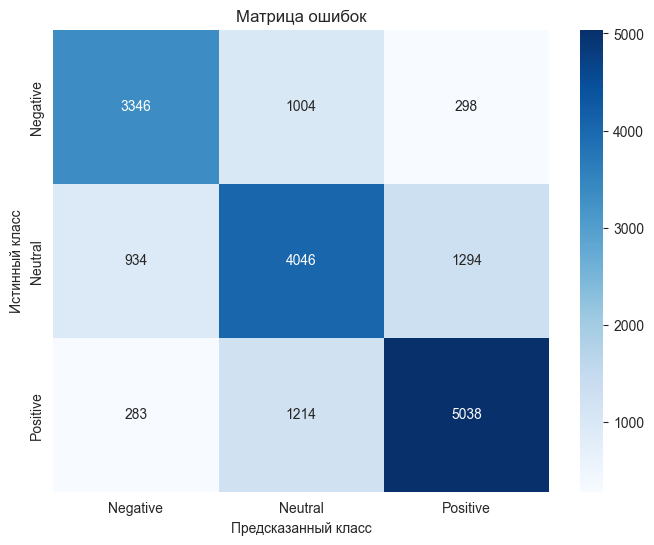

 
Пояснение:
Матрица ошибок показывает, сколько примеров каждого класса были правильно и неправильно классифицированы.
 
Accuracy (точность): 0.7120
 
Пояснение:
Accuracy - это доля правильно предсказанных примеров.
 
Precision (macro): 0.7130
Recall (macro): 0.7119
F1-score (macro): 0.7124
 
Пояснение:
Macro-усреднение вычисляет средние значения метрик для всех классов, придавая каждому классу одинаковый вес.
 
Отчёт по классификации:
              precision    recall  f1-score       support
Negative       0.722259  0.695998  0.708886   4648.000000
Neutral        0.642626  0.631973  0.637255   6274.000000
Positive       0.751322  0.782708  0.766694   6535.000000
accuracy       0.705448  0.705448  0.705448      0.705448
macro avg      0.705402  0.703560  0.704278  17457.000000
weighted avg   0.704519  0.705448  0.704782  17457.000000
 
Пояснение:
- precision: доля правильно предсказанных примеров для каждого класса.
- recall: доля правильно найденных примеров для каждого класса.
- f1-s

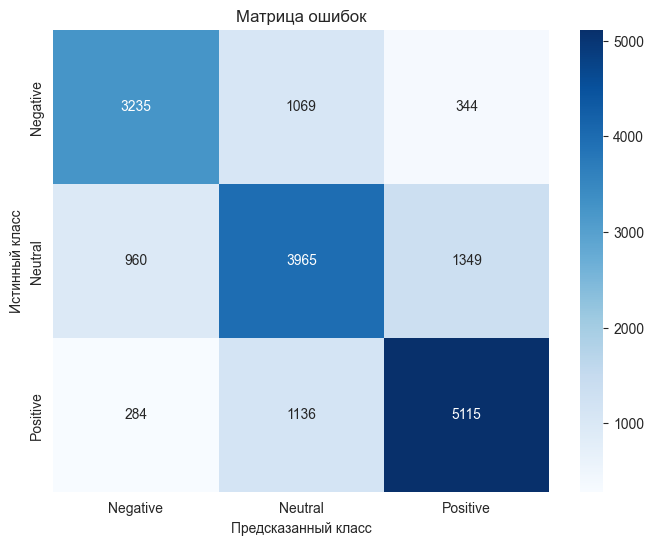

 
Пояснение:
Матрица ошибок показывает, сколько примеров каждого класса были правильно и неправильно классифицированы.
 
Accuracy (точность): 0.7054
 
Пояснение:
Accuracy - это доля правильно предсказанных примеров.
 
Precision (macro): 0.7054
Recall (macro): 0.7036
F1-score (macro): 0.7043
 
Пояснение:
Macro-усреднение вычисляет средние значения метрик для всех классов, придавая каждому классу одинаковый вес.
 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support



# Функция для вычисления метрик и построения графиков
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            _, predicted_labels = torch.max(outputs.logits, dim=1)
            all_labels.extend(inputs['labels'].cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    # 1. Classification отчет
    print("Отчёт по классификации:")
    report = classification_report(all_labels, all_predictions, target_names=label_dict.keys(), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df.to_string())
    print(" ")
    print("Пояснение:")
    print("- precision: доля правильно предсказанных примеров для каждого класса.")
    print("- recall: доля правильно найденных примеров для каждого класса.")
    print("- f1-score: среднее гармоническое precision и recall.")
    print("- support: количество примеров в каждом классе.")
    print(" ")

    # 2. Confusion matrix
    print("Матрица ошибок:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()
    print(" ")
    print("Пояснение:")
    print("Матрица ошибок показывает, сколько примеров каждого класса были правильно и неправильно классифицированы.")
    print(" ")

    # 3. Accuracy
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Accuracy (точность): {accuracy:.4f}")
    print(" ")
    print("Пояснение:")
    print("Accuracy - это доля правильно предсказанных примеров.")
    print(" ")

    # 4. Precision, Recall, F1-score (macro)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print(" ")
    print("Пояснение:")
    print("Macro-усреднение вычисляет средние значения метрик для всех классов, придавая каждому классу одинаковый вес.")
    print(" ")


# Оценка модели на валидационном и тестовом наборах
evaluate_model(model, validation_dataloader, device)
evaluate_model(model, test_dataloader, device)

потом я размечаю весь текст на уже готовой моделе, но с использованием данных о рейтинге места

In [ ]:

# Загрузка новых данных
new_data = pd.read_parquet('cleaned_data.parquet')


# Загрузка модели и токенизатора
tokenizer = tokenizer
model = model


# Функция для токенизации текста
def tokenize_text(text):
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokens

# Функция для определения тональности текста
def predict_sentiment(text):

    tokens = tokenize_text(text)

    # Ensure tokens are on the same device as the model
    tokens = {key: value.to(model.device) for key, value in tokens.items()}

    with torch.no_grad():
        outputs = model(**tokens)

    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return predicted_class




In [ ]:

# Применение функций
tqdm.pandas()
data['predicted_sentiment'] = data['text'].progress_apply(predict_sentiment)


# Вывод строк, где знак тональности не соответствует рейтингу
mismatched = data[data['predicted_sentiment'] != data['tone']]
print(mismatched.length)

In [ ]:


# Предсказание тональности для новых данных
tqdm.pandas()
new_data['predicted_sentiment'] = new_data['text'].progress_apply(predict_sentiment)

# Сравнение предсказанной тональности с истинной
mismatched = new_data[new_data['predicted_sentiment'] != new_data['tone']]

# Анализ результатов
print("Количество несовпадений:", len(mismatched))

 #Вывод примеров несовпадений (опционально)
print(mismatched[['text', 'tone', 'predicted_sentiment']].head())

# Детальный анализ с помощью функции evaluate_model
evaluate_model(model, DataLoader(prepare_data(new_data), batch_size=16), device)

100%|██████████| 87285/87285 [17:25<00:00, 83.48it/s]


Количество несовпадений: 22289
                                                 text  tone  \
0   Ги пер весьма приемлемый. Огромный ассортимент...     1   
4   На фото не сам олень).\nЛюбимое место для отды...     2   
5   Ресторан по адресу Богатырский пр. 55 к1 посещ...     1   
6   Очень приятно погулять, когда ещё нет очень мн...     2   
10  Маникюр+педикюр без покрытия 45 мин. Уходя нич...     1   

    predicted_sentiment  
0                     2  
4                     1  
5                     0  
6                     1  
10                    0  


TypeError: evaluate_model() takes 3 positional arguments but 4 were given